In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
from sklearn import datasets

In [4]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# 論文用demographic dataの作成（1群）

In [1]:
def get_stats(df, col_names):
    """
    df.describeから、目的の変数の基礎統計量をまとめてDataFrameを返す
    2値（LR、性別など）→最大のものとその個数、割合
    連続変数→平均（SD）
    それ以外は未対応
    """
    
    des_df = df[col_names].describe(include="all")
    
    res_df = []
    
    for col_name in col_names:
        print(col_name)
        if des_df.loc["unique", col_name] == 2:
            col = df[col_name]
            
            val_c_index = col.value_counts().index
            val_c_values = col.value_counts().tolist()
            
            col_res = f"{col_name}({val_c_index[0]})"
            val_res = f"{val_c_values[0]}/{sum(val_c_values)}({int(val_c_values[0]*100/sum(val_c_values))}%)"
            res_df.append([col_res, val_res])
        
        elif des_df.loc["mean", col_name]:
            col = df[col_name]
            mean = round(col.mean(), 1)
            sd = round(col.std(), 1)
            res_df.append([f"{col_name}(SD)", f"{mean}({sd})"])
        
    res_df = pd.DataFrame(res_df)
    
    return res_df

# 論文用demographic dataの作成（2群比較）

In [24]:
def make_demographic(df, group_col, **kwargs):
    """
    stackしたデータから独立な2群(group_col)に分けてdemographic dataを作成する
    **kwargs:比較したい性別や年齢などを指定。変数名="c" or "m" のモードに対応
    LR="c", sex="c", age="m"のように指定し、モードcは**％(**/**)、mは平均±SDを出力
    """
    res_df = pd.DataFrame(columns=kwargs.keys())
    for param, func in kwargs.items():
        if func == "c":
            piv = pd.crosstab(df[param], df[group_col], margins=True)
            x2, p, dof, e = st.chi2_contingency(piv, correction=False)
            
            rates = [round(piv.iloc[0, i] / piv.iloc[2, i] * 100, 1) for i in range(2)]
            row = {}
            for i in range(2):
                row[piv.columns[i]] = "{0}%({1}/{2})".format(rates[i], piv.iloc[0, i], piv.iloc[2, i])
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
            
        elif func == "m":
            piv = df.pivot_table(values=param, columns=group_col, aggfunc=["mean", "std"])
            means = [round(piv.iloc[0, i], 1) for i in range(2)]
            stds = [round(piv.iloc[0, i+2], 1) for i in range(2)]
            
            row = {}
            for i in range(2):
                row[piv.columns[i][1]] = "{0}±{1}".format(means[i], stds[i])
            A = [df[df[group_col]==piv.columns[i][1]][param] for i in range(2)]
            p = st.ttest_ind(*A, equal_var=False).pvalue
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
        
    return res_df.T

In [22]:
df.describe(include="all")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,virginica
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [27]:
dic = {"sepal length (cm)":"m", "sepal width (cm)": "m"}
tmp_df = df.query("target!='setosa'")
make_demographic(tmp_df, "target", **dic)

,versicolor,virginica,p value
sepal length (cm),5.9±0.5,6.6±0.6,p<0.01
sepal width (cm),2.8±0.3,3.0±0.3,p<0.01


# Tukeyの多重比較結果をシンプルなDataFrameに変換する

In [1]:
def Tukey_to_dataframe(df):
    columns = ["group1", "group2", "meandiff", "p", "lower", "upper", "reject"]
    df = df.iloc[1:,].reset_index()
    df.columns = columns
    return df

# Bland-Altman分析

In [322]:
import math
import pandas as pd
import seaborn as sns
import scipy.stats as st

def Bland_Altman_init(df, col1, col2, alpha=0.05):

    df = df.copy()
    df["mean"] = (df[col1] + df[col2]) / 2
    df["diff"] = df[col1] - df[col2] # col1 - col2
    df["r_diff"] = df["diff"] * 100 / df["mean"]
    
    return df

def Bland_Altman_result(df, alpha=0.05, is_relative=False):
    diff_col = "diff"
    if is_relative:
        diff_col = "r_diff"

    print("Bland-Altman plot")

    z_a = st.norm.ppf(1-alpha)
    t_a = st.t.ppf(df=n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
    LOA_up = df[diff_col].mean() + z_a * df[diff_col].std()
    LOA_low = df[diff_col].mean() - z_a * df[diff_col].std()
    LOA_conf = t_a * math.sqrt(3 * df[diff_col].std()**2 / n)
    
    r, p, corr_low, corr_up = get_corr(df, "mean", diff_col, alpha)

    r, corr_low, corr_up= round(r,3), round(corr_low,3), round(corr_up, 3)
    is_add_bias = not(LOA_low + LOA_conf < 0 < LOA_up - LOA_conf)
    is_prop_bias = p < alpha
    p = "<0.01" if p < 0.01 else round(p,3)

    print(f"平均：{df[diff_col].mean()}")
    print(f"上側{100-alpha*100}%LOA：\
          {round(LOA_up,3)}[{round(LOA_up-LOA_conf,3)}~{round(LOA_up+LOA_conf,3)}]")
    print(f"下側{100-alpha*100}%LOA：\
          {round(LOA_low,3)}[{round(LOA_low-LOA_conf,3)}~{round(LOA_low+LOA_conf,3)}]")
    print(f"相関係数：{r}[{corr_low}~{corr_up}] p {p}")
    print(f"加算誤差：{is_add_bias}")
    print(f"比例誤差：{is_prop_bias}")


def Bland_Altman_plot(ba_df, true_col, pred_col, mark_color, ax, is_relative=False):
    """
    df: Bland_Altman_initで返ってきたdfを入れる
    ax: subplot用
    """
    
    # 各種設定項目
    diff_col = "r_diff" if is_relative else "diff"

    mean_color = "black"
    LOA_color = "black"
    conf_color = "gray"

    # 各種統計計算値
    n = len(ba_df[true_col])
    alpha = 0.05
    z_a = st.norm.ppf(1-alpha)
    t_a = st.t.ppf(df=n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
    LOA_up = ba_df[diff_col].mean() + z_a * ba_df[diff_col].std()
    LOA_low = ba_df[diff_col].mean() - z_a * ba_df[diff_col].std()
    LOA_conf = t_a * math.sqrt(3 * ba_df[diff_col].std()**2 / n)


    sns.scatterplot(data=ba_df, x="mean", y=diff_col, s=70, color=mark_color, ax=ax, label=area)
    ax.legend(loc="upper left")
    #平均
    ax.axhline(ba_df[diff_col].mean(), color=mean_color, linestyle="--")

    #上側LOA
    ax.axhline(LOA_up, color=LOA_color, linestyle="--")
    #上側LOAの信頼区間
    ax.axhline(LOA_up + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_up - LOA_conf, color=conf_color, linestyle=':')

    #下側LOA
    ax.axhline(LOA_low, color=LOA_color, linestyle="--")
    #下側LOAの信頼区間
    ax.axhline(LOA_low + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_low - LOA_conf, color=conf_color, linestyle=':')

    ax.set_xlabel("Mean")
    ax.set_ylabel("Relative Difference(%)" if is_relative else "Difference")

    
def get_corr(df, col1, col2, alpha=0.05):
    a, b = df[col1], df[col2]        
    r, p = st.pearsonr(a, b)
    n = len(a)
    z= 0.5 * math.log((1+r)/(1-r))
    za = st.norm.ppf(1-alpha)
    zl = z - za * math.sqrt(1/(n-3))
    zu = z + za * math.sqrt(1/(n-3))
    rhol = (math.exp(2 * zl) - 1 )/ (math.exp(2 * zl) +1 )
    rhou = (math.exp(2 * zu) - 1 )/ (math.exp(2 * zu) +1 )
    return r, p, rhol, rhou

Bland-Altman plot
平均：0.009041373764486937
上側95.0%LOA：          0.146[0.12~0.171]
下側95.0%LOA：          -0.127[-0.153~-0.102]
相関係数：0.775[0.692~0.838] p <0.01
加算誤差：False
比例誤差：True
Bland-Altman plot
平均：-0.0036671915682623883
上側95.0%LOA：          0.142[0.114~0.169]
下側95.0%LOA：          -0.149[-0.176~-0.121]
相関係数：0.637[0.516~0.732] p <0.01
加算誤差：False
比例誤差：True
Bland-Altman plot
平均：-0.009576887337179655
上側95.0%LOA：          0.132[0.105~0.158]
下側95.0%LOA：          -0.151[-0.178~-0.124]
相関係数：0.534[0.392~0.651] p <0.01
加算誤差：False
比例誤差：True


Text(0.5, 0.98, 'Bland-Altman analysis')

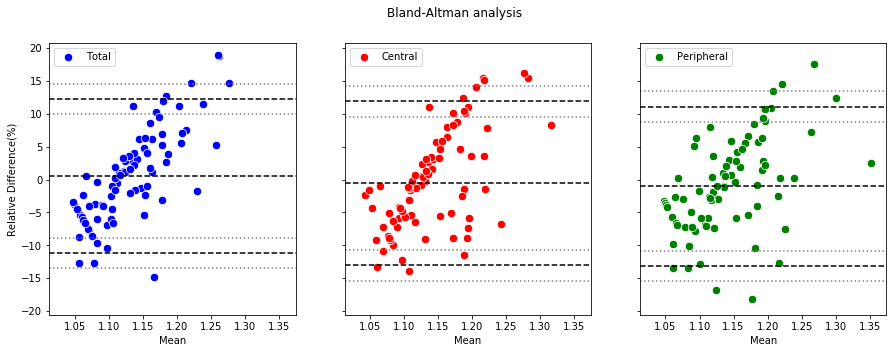

In [323]:
df = pd.read_csv("data/data2.csv", encoding="shift-jis").rename(columns={"baPWV": "Actual baPWV"})
true_col = "Actual baPWV"
pred_col = "Predicted baPWV"
R_col_names = {"Total": "R) 予測全体baPWV", "Peripheral": "R) 予測周囲baPWV", "Central": "R) 予測中心baPWV"}
L_col_names = {"Total": "L) 予測全体baPWV", "Peripheral": "L) 予測周囲baPWV", "Central": "L) 予測中心baPWV"}
areas = ["Total", "Central", "Peripheral"]
mark_colors = ["blue", "red", "green"]

f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))

for i, area in enumerate(areas):
    R_col = R_col_names[area]
    L_col = L_col_names[area]
    ba_df = df[[true_col, R_col, L_col]].copy()
    # 予測値はLとRのうち大きいほうを採用
    ba_df[pred_col] = ba_df.apply(lambda x: max(x[L_col], x[R_col]), axis=1)
    # 前処理
    ba_df = Bland_Altman_init(ba_df[[true_col, pred_col]], true_col, pred_col)

    Bland_Altman_plot(ba_df, true_col, pred_col, mark_colors[i], axes[i], True)

    Bland_Altman_result(ba_df)

plt.suptitle("Bland-Altman analysis")